# Figure generation

## Imports

In [18]:
from figure_utils.fishbait_figures import PlotKFoldSingleBarUsingWAvgPreds, PlotKFoldComboBarUsingWAvgPreds, PlotKFoldResidualHistUsingWAvgPreds
from figure_utils.fishbait_figures import PlotBaseModelLossfunResults, PlotPCA_CLSProjection
from figure_utils.fishbait_figures import PlotQSARresidualScatter, PlotQSARcompBarUsingWAvgPredsInterersect, PlotQSARcompScatter, PlotQSARCoverageComboBar
from figure_utils.preprocess_data import Preprocess10x10Fold, GroupDataForPerformance
from figure_utils.preprocess_qsar import LoadQSAR, MatchQSAR, PrepareQSARData

In [14]:
import numpy as np

## Make figures

### Non endpoint specific

In [4]:
def PlotNonEndpointSpecific(combomodel, save_figures: bool=False):

    if save_figures:
        PlotKFoldComboBarUsingWAvgPreds(f"./figures_for_publication/combo_model_{combomodel}_performance_10x10_CV", combomodel)
        PlotKFoldSingleBarUsingWAvgPreds(f"./figures_for_publication/single_model_performance_10x10_CV")
        for inside_AD in [True, False]:
            if inside_AD:
                AD='AD'
            else:
                AD='allpreds'

            PlotQSARCoverageComboBar(f"./figures_for_publication/QSAR_coverage_comparison_{AD}", inside_AD=inside_AD)
                
        PlotBaseModelLossfunResults(f"./figures_for_publication/base_model_and_lossfun")
    else:
        PlotKFoldComboBarUsingWAvgPreds(None, combomodel)
        PlotKFoldSingleBarUsingWAvgPreds(None)
        for inside_AD in [True, False]:
            if inside_AD:
                AD='AD'
            else:
                AD='allpreds'

            PlotQSARCoverageComboBar(None, inside_AD=inside_AD)
                
        PlotBaseModelLossfunResults(None)
        
    

c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_data.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_data.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_data.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

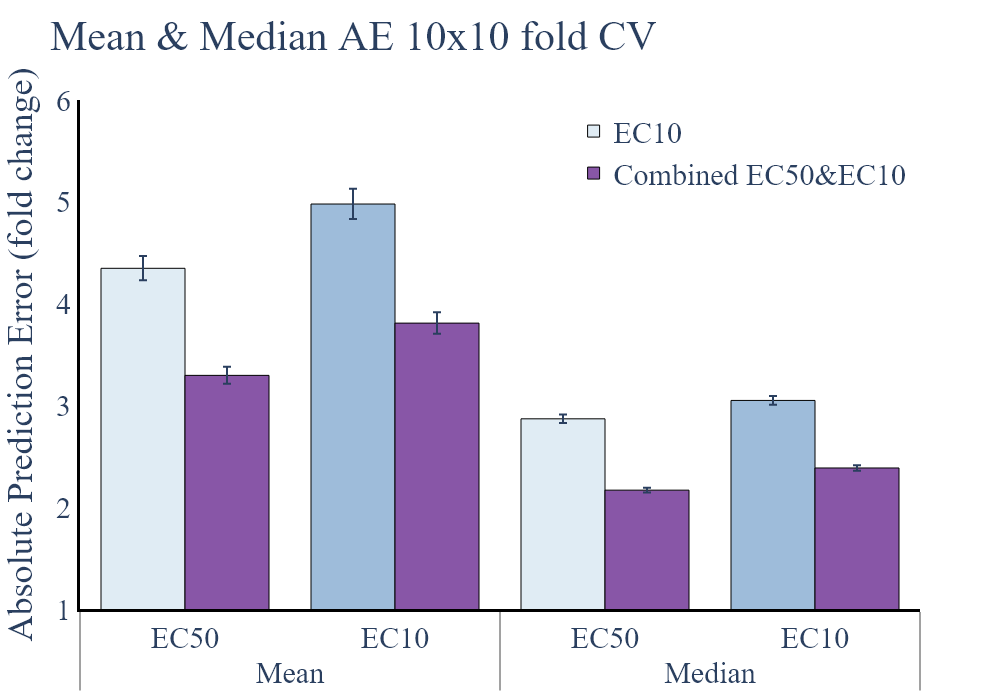

c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_data.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_data.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



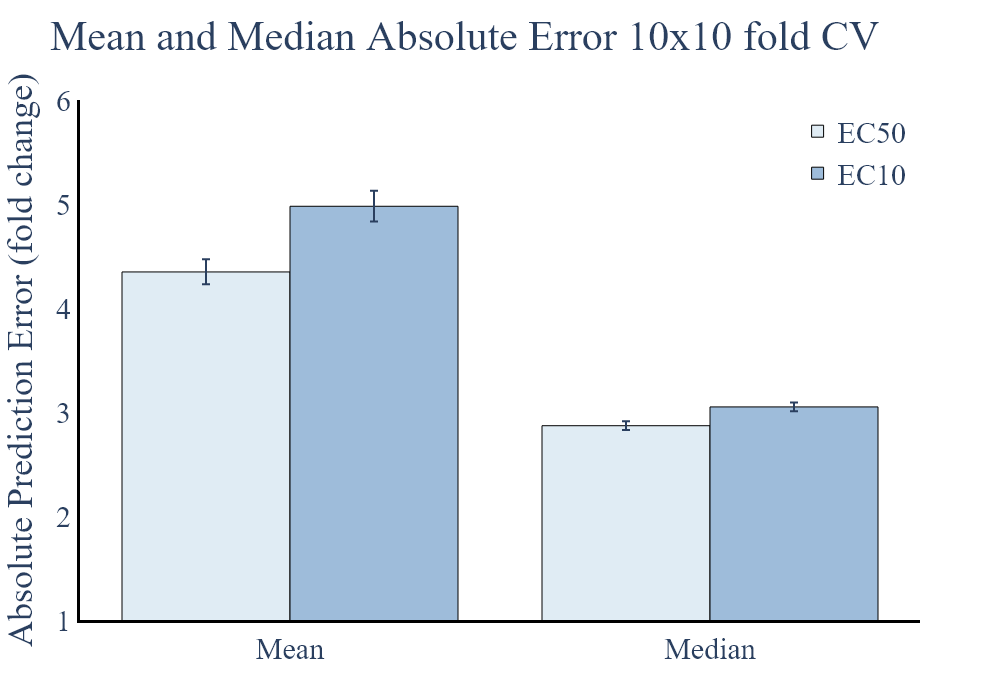

c:\Users\skall\Anaconda3\envs\ecotoxformer\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

divide by zero encountered in log10

c:\Users\skall\Anaconda3\envs\ecotoxformer\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

invalid value encountered in log10



Removed 801 rows
Removed 10780 rows
Removed 0 rows


c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_data.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\skall\Anaconda3\envs\ecotoxformer\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

divide by zero encountered in log10



Removed 193 rows
Removed 3087 rows
Removed 0 rows


c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_data.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



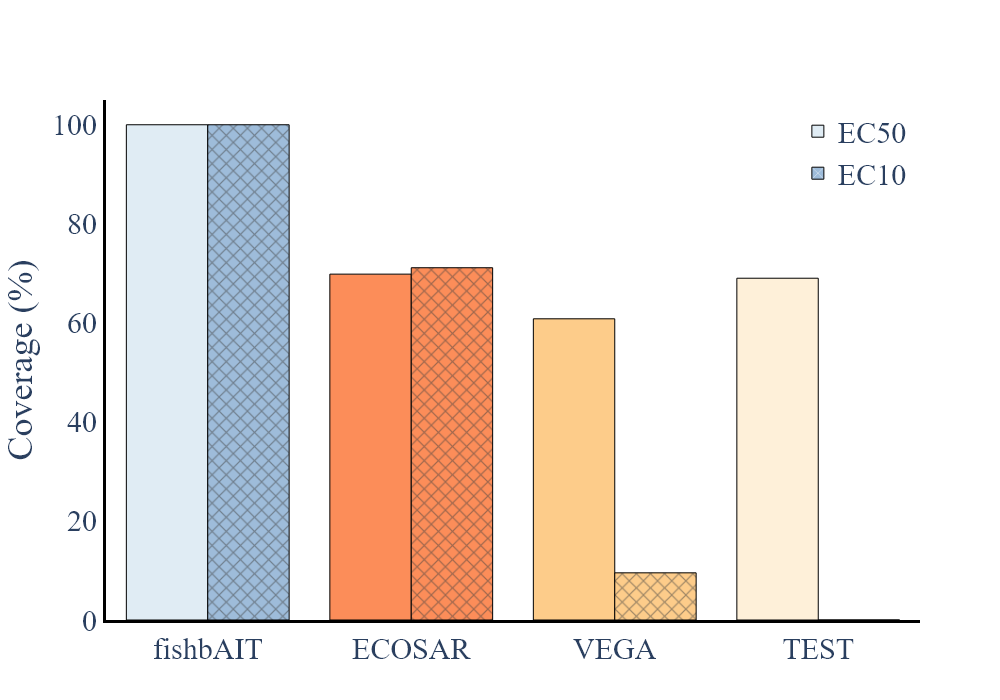

c:\Users\skall\Anaconda3\envs\ecotoxformer\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

divide by zero encountered in log10

c:\Users\skall\Anaconda3\envs\ecotoxformer\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

invalid value encountered in log10

c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_data.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\skall\Anaconda3\envs\ecotoxformer\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

divide by zero encountered in log10

c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_data.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

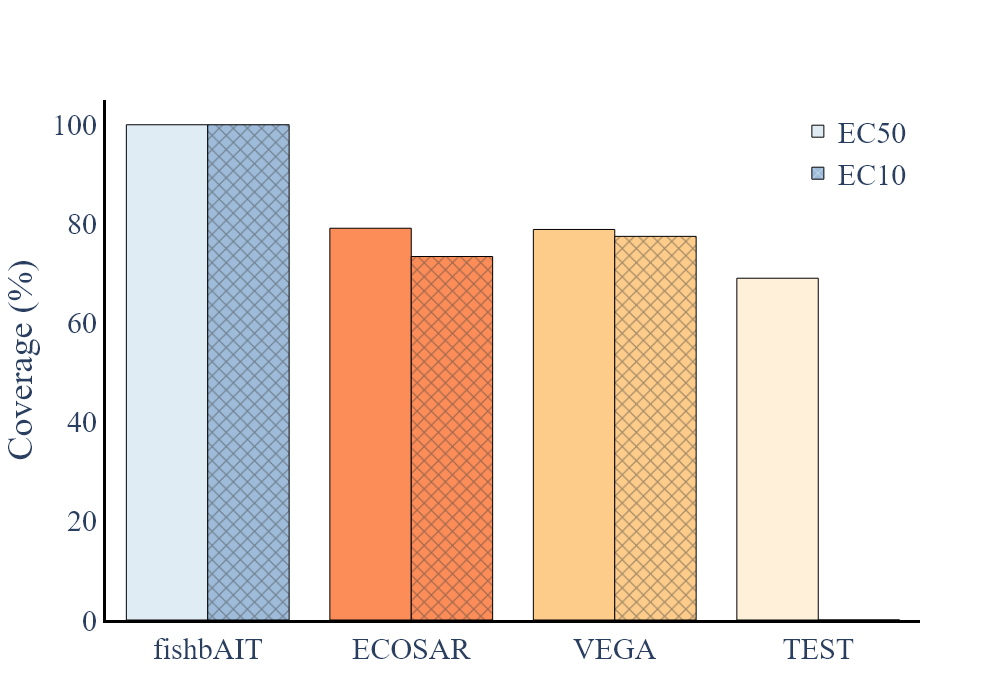

In [5]:
PlotNonEndpointSpecific('EC50EC10_withoverlap', save_figures=False)

### Endpoint-specific

In [21]:
def PlotEndpointSpecific(endpoint, effect_for_qsar_comp, name, inside_AD, durations, save_figures: bool=False):
    if inside_AD:
        AD='AD'
    else:
        AD='allpreds'
    if effect_for_qsar_comp == ['all']:
        effect_for_qsar_comp = ['MOR','DVP','ITX','MPH','REP','POP','GRO']

    # ----------- fishbAIT ------------------------
    avg_predictions = Preprocess10x10Fold(name=name)
    avg_predictions = avg_predictions[avg_predictions.effect.isin(effect_for_qsar_comp)]
    weighted_avg_predictions = GroupDataForPerformance(avg_predictions=avg_predictions)
    _, mean_L1, median_L1, RMSE, se = (weighted_avg_predictions.residuals, 
                                    weighted_avg_predictions.L1error.mean(), 
                                    weighted_avg_predictions.L1error.median(),
                                    np.sqrt((weighted_avg_predictions.residuals**2).mean()),
                                    np.std(weighted_avg_predictions.L1error)/np.sqrt(len(weighted_avg_predictions))
                                    )
    print(f'''
    (weighted avg) Avg prediction error: {mean_L1}
    (weighted avg) Median prediction error: {median_L1}
    (weighted avg) RMSE: {RMSE}
    (weighted avg) standard error: {se}
    ''')

    if save_figures:
        PlotKFoldResidualHistUsingWAvgPreds(f"./figures_for_publication/{endpoint}/{name}_weightedavgpreds_10x10fold_hist", name=name, endpoint=endpoint)
    else:
        PlotKFoldResidualHistUsingWAvgPreds(savepath=None, name='EC50', endpoint='EC50')

    # ----------- QSAR ------------------------
    ECOSAR, VEGA, TEST = LoadQSAR(endpoint=endpoint)
    ECOSAR, TEST, VEGA = PrepareQSARData(ECOSAR, TEST, VEGA, inside_AD=inside_AD, remove_experimental=True)
    TEST_dict = dict(zip(TEST.original_SMILES, TEST.value))
    VEGA_dict = dict(zip(VEGA.original_SMILES, VEGA.value))
    ECOSAR_dict = dict(zip(ECOSAR.original_SMILES, ECOSAR.value))

    qsar_preds = MatchQSAR(avg_predictions, ECOSAR_dict, TEST_dict, VEGA_dict, endpoint=endpoint, duration=durations)
    qsar_preds[['ECOSAR_residuals','VEGA_residuals','TEST_residuals']] = qsar_preds[['ECOSAR','VEGA','TEST']] - qsar_preds[['labels']].to_numpy()
    weighted_avg_qsar_preds = GroupDataForPerformance(qsar_preds)
    if endpoint == 'EC10':
        weighted_avg_qsar_preds[['TEST', 'TEST_residuals']] = None
    
    if save_figures:
        PlotQSARcompBarUsingWAvgPredsInterersect(f"./figures_for_publication/{endpoint}/{name}_weightedavgpreds_10x10CV_QSAR_comp_{AD}_SMILES_{''.join(effect_for_qsar_comp)}_effect", predictions=weighted_avg_qsar_preds, endpoint=endpoint)
        PlotQSARcompScatter(f"./figures_for_publication/{endpoint}/{name}_weightedavgpreds_10x10CV_QSAR_scatter_{AD}_SMILES_{''.join(effect_for_qsar_comp)}_effect", predictions=weighted_avg_qsar_preds, endpoint=endpoint)
        PlotQSARresidualScatter(f"./figures_for_publication/{endpoint}/{name}_10x10CV_QSAR_residualscatter_{AD}_SMILES_{''.join(effect_for_qsar_comp)}_effect", predictions=qsar_preds, endpoint=endpoint)
        PlotQSARresidualScatter(f"./figures_for_publication/{endpoint}/{name}_weightedavgpreds_10x10CV_QSAR_residualscatter_{AD}_SMILES_{''.join(effect_for_qsar_comp)}_effect", predictions=weighted_avg_qsar_preds, endpoint=endpoint)
    else:
        PlotQSARcompBarUsingWAvgPredsInterersect(None, predictions=weighted_avg_qsar_preds, endpoint=endpoint)
        PlotQSARcompScatter(None, predictions=weighted_avg_qsar_preds, endpoint=endpoint)
        PlotQSARresidualScatter(None, predictions=qsar_preds, endpoint=endpoint)
        PlotQSARresidualScatter(None, predictions=weighted_avg_qsar_preds, endpoint=endpoint)

In [26]:
ENDPOINT = 'EC10'
NAME = 'EC10'
EFFECT_FOR_QSAR_COMP = ['all']
INSIDE_AD = True
DURATIONS = ['short exposure','medium exposure', 'long exposure'] # <= 96h, <= 1week, >1week

c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_data.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




    (weighted avg) Avg prediction error: 0.6970664410514672
    (weighted avg) Median prediction error: 0.48413519859314014
    (weighted avg) RMSE: 0.9895594568631402
    (weighted avg) standard error: 0.012929523735026371
    


c:\Users\skall\OneDrive - Chalmers\Documents\git_repo\development\figures\figure_utils\preprocess_data.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



13 >3
    83 >2
    533 >1


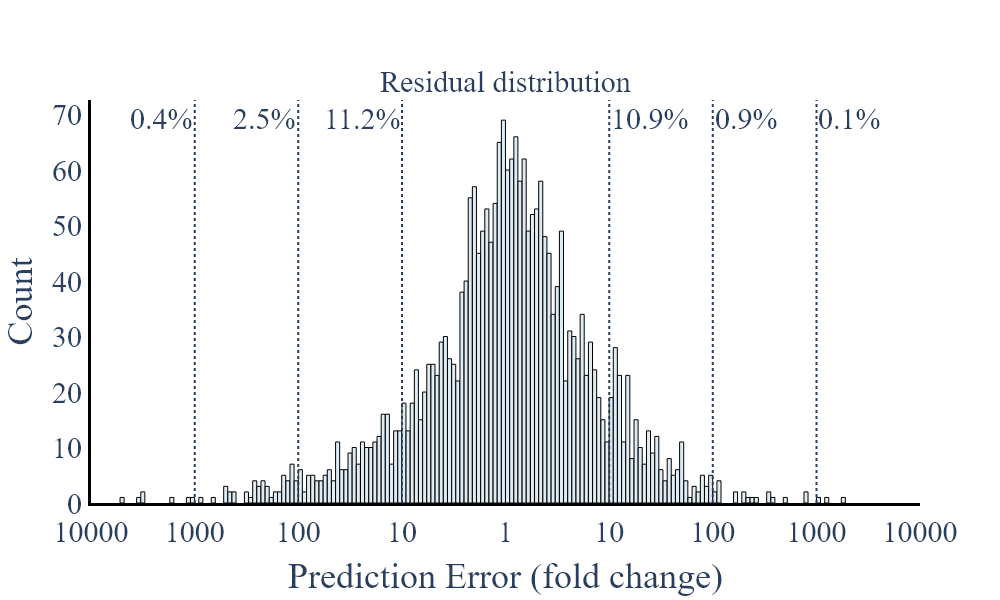

c:\Users\skall\Anaconda3\envs\ecotoxformer\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

divide by zero encountered in log10



Removed 193 rows
Removed 3087 rows
Removed 0 rows
(156, 22)


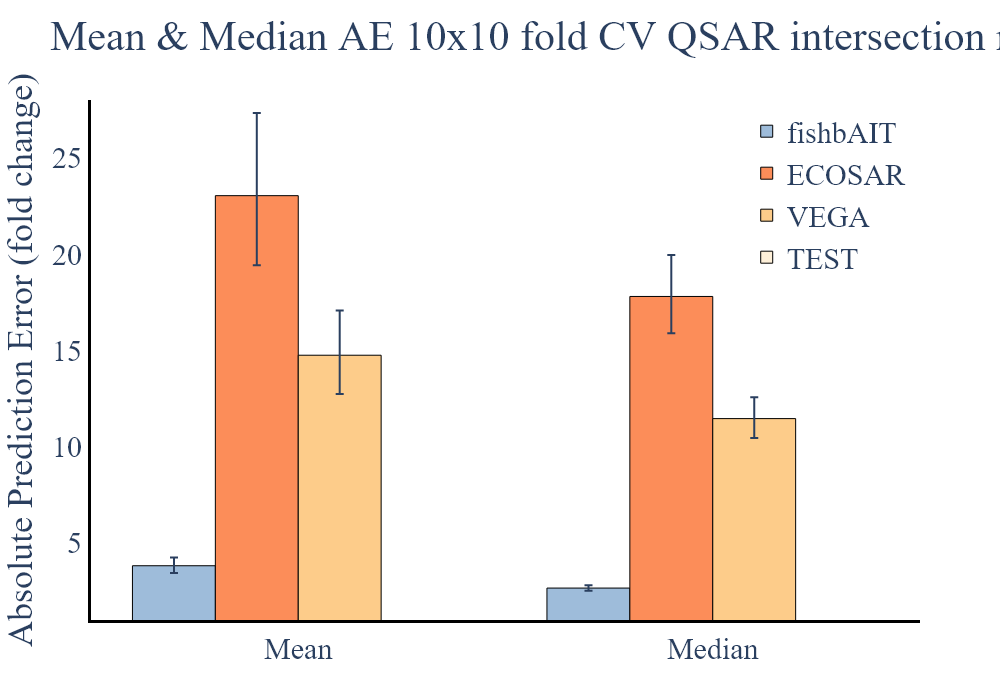

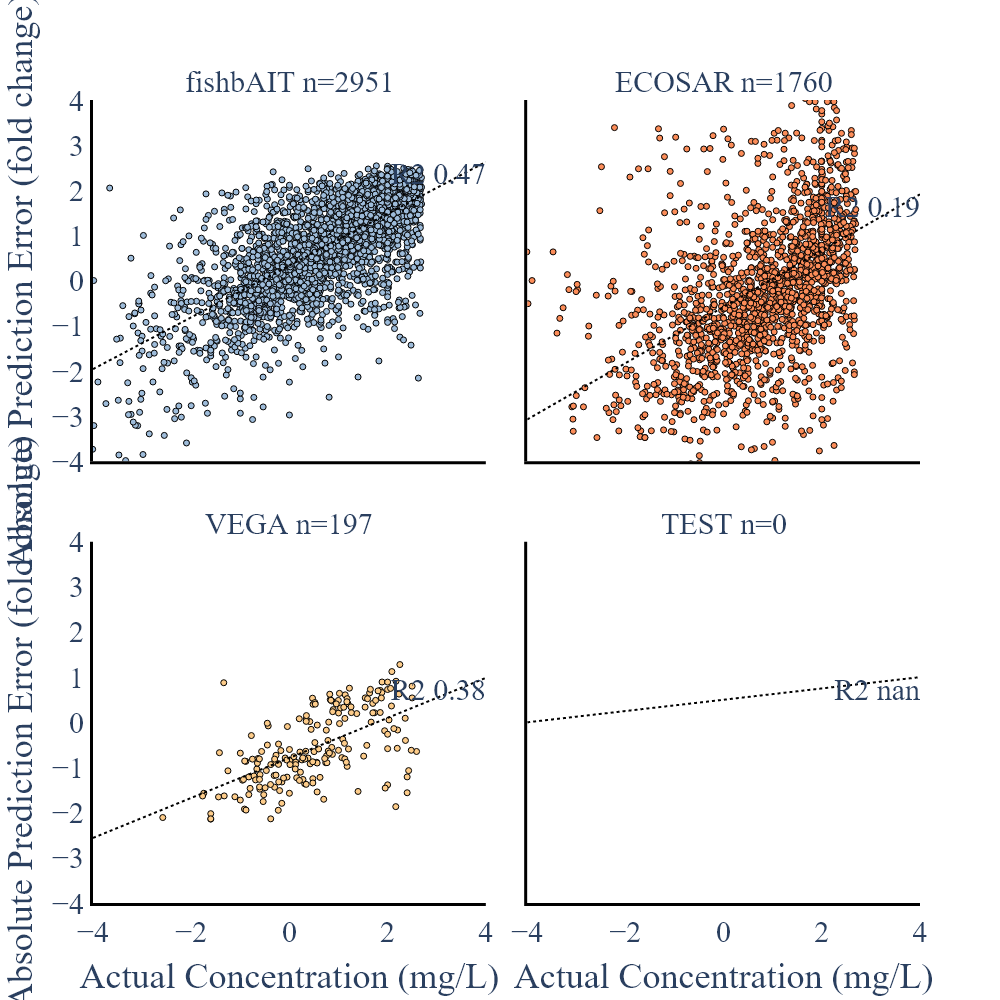

EC10 >1 6075
EC10 >2 1953
EC10 >3 673
ECOSAR >1 6116
ECOSAR >2 3098
ECOSAR >3 1570
VEGA >1 445
VEGA >2 99
VEGA >3 31


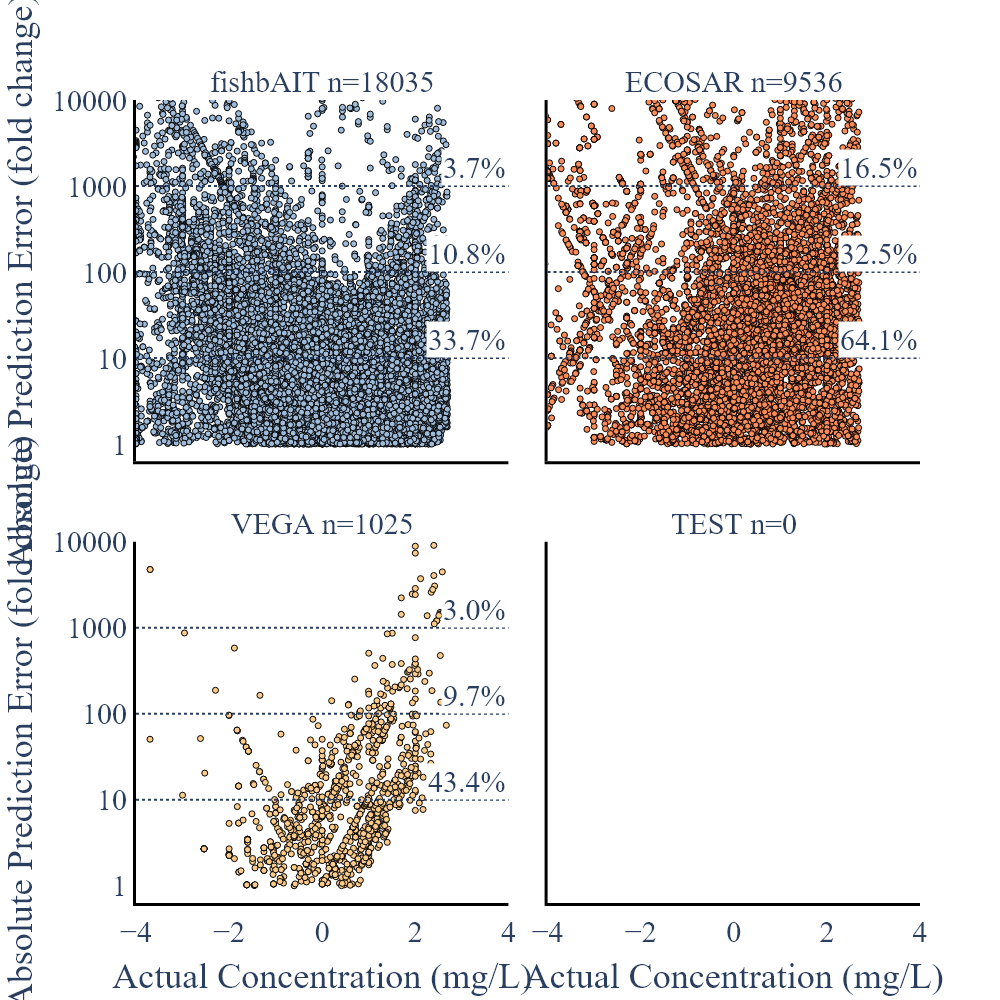

EC10 >1 710
EC10 >2 171
EC10 >3 36
ECOSAR >1 1133
ECOSAR >2 486
ECOSAR >3 189
VEGA >1 102
VEGA >2 25
VEGA >3 8


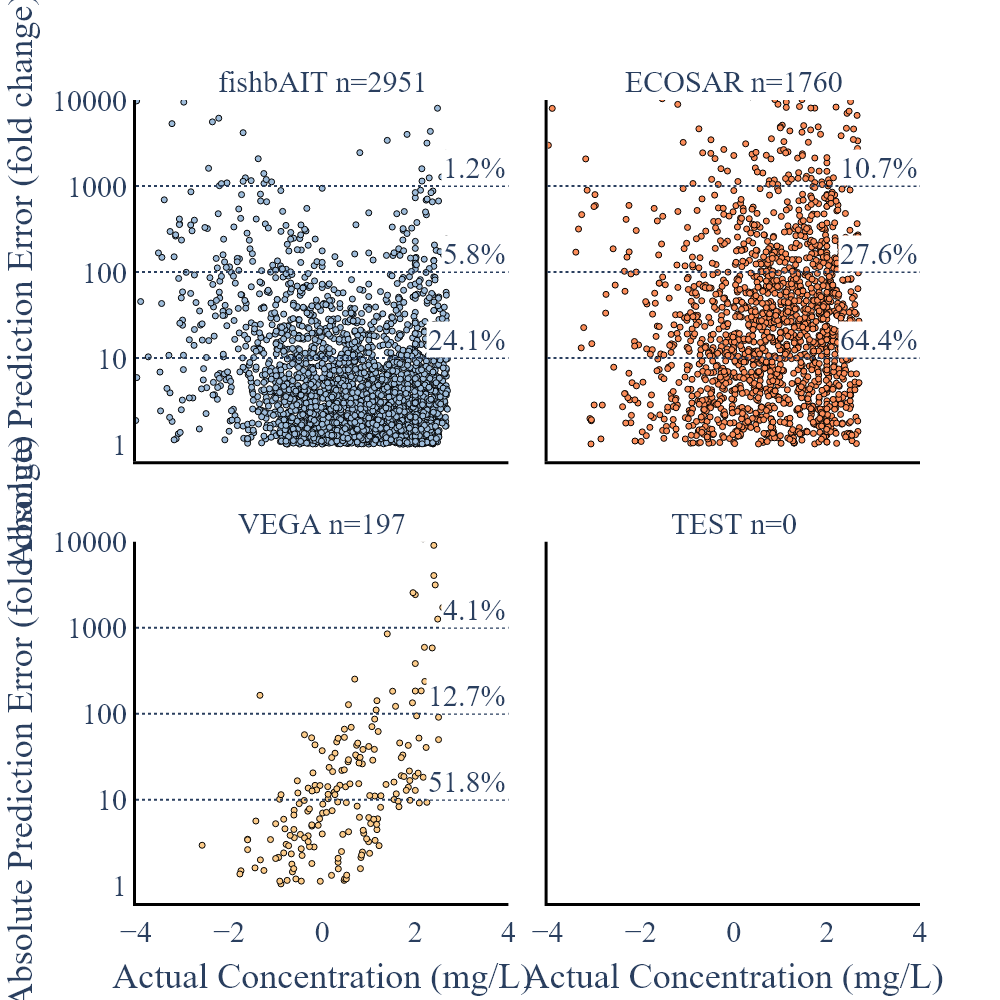

In [27]:
PlotEndpointSpecific(endpoint=ENDPOINT, effect_for_qsar_comp=EFFECT_FOR_QSAR_COMP, name=NAME, inside_AD=INSIDE_AD, durations=DURATIONS, save_figures=False)

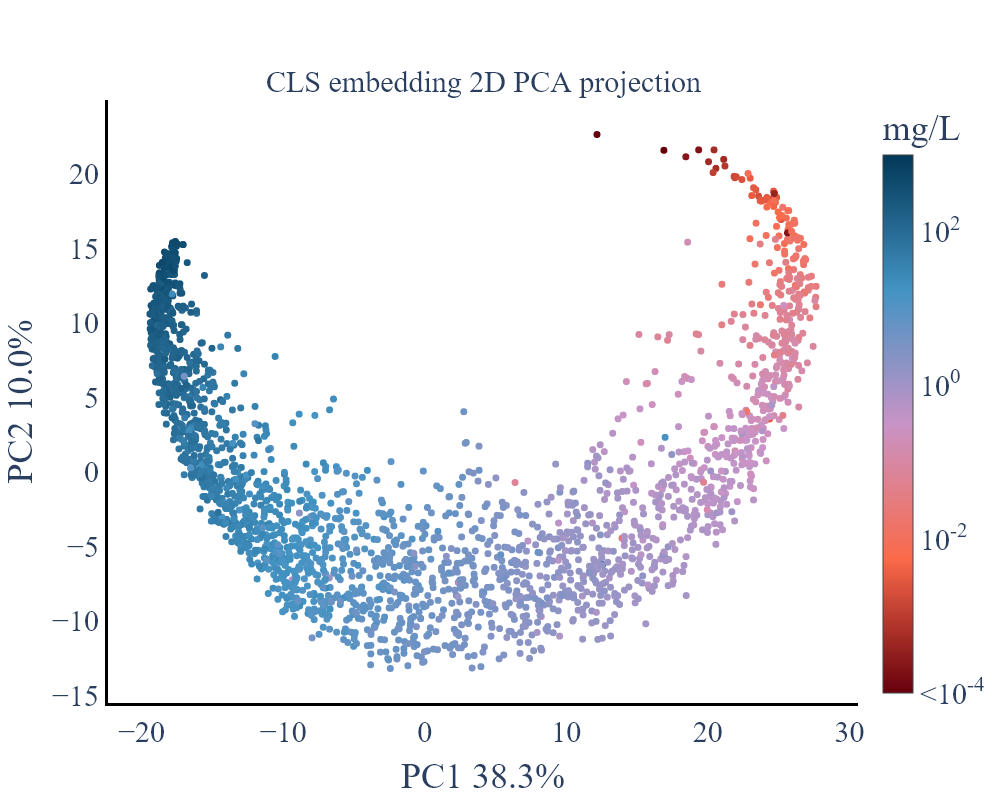

In [25]:
PlotPCA_CLSProjection(savepath=None, endpoint=ENDPOINT, flipaxis=False)